In [22]:
import os

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:

new_sales_data = pd.read_csv("NEW SALES DATA.csv")

print(new_sales_data.head(10))

  product_code customer_code market_code order_date  sales_qty  sales_amount  \
0      Prod279        Cus020     Mark011  11-Oct-17          1           102   
1      Prod279        Cus020     Mark011  18-Oct-17          1           102   
2      Prod279        Cus020     Mark011  19-Oct-17          1           102   
3      Prod279        Cus020     Mark011   8-Nov-17          1           102   
4      Prod279        Cus020     Mark011   9-Mar-18          1           102   
5      Prod279        Cus020     Mark011  20-Mar-18          1           102   
6      Prod279        Cus020     Mark011  22-Mar-18          1           102   
7      Prod279        Cus020     Mark011  23-Mar-18          1           102   
8      Prod279        Cus020     Mark011  29-Mar-18          1           102   
9      Prod279        Cus020     Mark011  16-Apr-18          1           102   

  currency  profit_margin_percentage  profit_margin  cost_price  \
0      INR                      0.39          39.78 

In [25]:
new_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148395 entries, 0 to 148394
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product_code              148395 non-null  object 
 1   customer_code             148395 non-null  object 
 2   market_code               148395 non-null  object 
 3   order_date                148395 non-null  object 
 4   sales_qty                 148395 non-null  int64  
 5   sales_amount              148395 non-null  int64  
 6   currency                  148395 non-null  object 
 7   profit_margin_percentage  148395 non-null  float64
 8   profit_margin             148395 non-null  float64
 9   cost_price                148395 non-null  float64
 10  normal_sales_amount       148395 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 12.5+ MB


In [26]:
# Keep only 'order_date' and 'sales_qty' columns
new_sales_data = new_sales_data[['order_date', 'sales_qty']]

new_sales_data = new_sales_data.rename(columns={
    'order_date': 'date',
    'sales_qty': 'sales'
})

print(new_sales_data.head())


        date  sales
0  11-Oct-17      1
1  18-Oct-17      1
2  19-Oct-17      1
3   8-Nov-17      1
4   9-Mar-18      1


In [27]:
# Convert 'date' column to datetime formate
new_sales_data['date'] = pd.to_datetime(new_sales_data['date'])

# Convert 'date' column to monthly periods
new_sales_data['date'] = new_sales_data['date'].dt.to_period("M")

# Group data by 'date' and calculate the sum of 'sales'
monthly_sales = new_sales_data.groupby('date')['sales'].sum().reset_index()

# Convert 'date' back to a timestamp for plotting or further analysis
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
print(monthly_sales.head(10))


        date  sales
0 2017-10-01  66595
1 2017-11-01  88448
2 2017-12-01  79419
3 2018-01-01  87873
4 2018-02-01  87583
5 2018-03-01  90337
6 2018-04-01  91644
7 2018-05-01  92525
8 2018-06-01  86868
9 2018-07-01  87613


C:\Users\user\AppData\Local\Temp\ipykernel_10024\721316077.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_sales_data['date'] = pd.to_datetime(new_sales_data['date'])


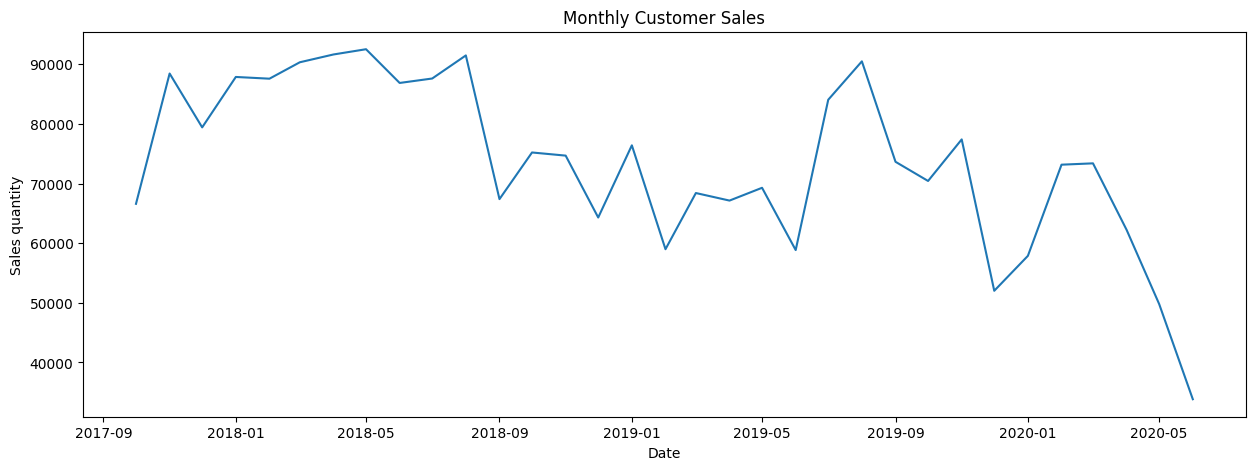

In [28]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales quantity")
plt.title("Monthly Customer Sales")
plt.show()

In [29]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2017-11-01,88448,21853.0
2,2017-12-01,79419,-9029.0
3,2018-01-01,87873,8454.0
4,2018-02-01,87583,-290.0
5,2018-03-01,90337,2754.0
6,2018-04-01,91644,1307.0
7,2018-05-01,92525,881.0
8,2018-06-01,86868,-5657.0
9,2018-07-01,87613,745.0
10,2018-08-01,91483,3870.0


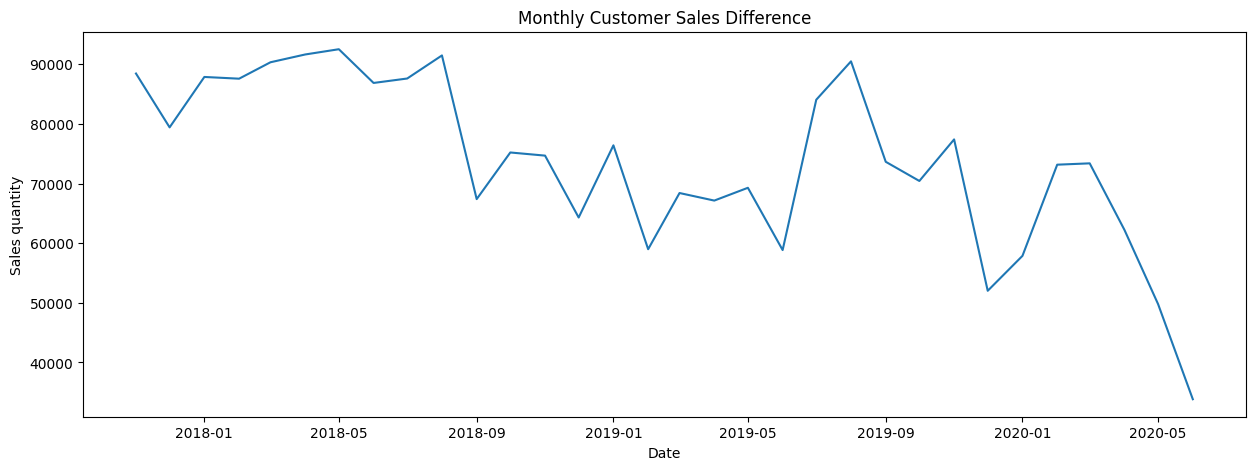

In [30]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales ['sales'])
plt.xlabel("Date")
plt.ylabel("Sales quantity")
plt.title("Monthly Customer Sales Difference")
plt.show()

In [31]:
supervised_data=monthly_sales.drop(['date','sales'], axis=1)

In [32]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0,2754.0,-290.0,8454.0,-9029.0,21853.0
1,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0,2754.0,-290.0,8454.0,-9029.0
2,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0,2754.0,-290.0,8454.0
3,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0,2754.0,-290.0
4,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0,2754.0
5,-1267.0,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0,1307.0
6,2145.0,-1267.0,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0,881.0
7,-10444.0,2145.0,-1267.0,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0,-5657.0
8,25212.0,-10444.0,2145.0,-1267.0,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0,745.0
9,6439.0,25212.0,-10444.0,2145.0,-1267.0,9423.0,-17423.0,12107.0,-10381.0,-527.0,7822.0,-24098.0,3870.0


In [33]:
train_data = supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data shape:", train_data.shape)
print("Test Data Shape:",test_data.shape)

Train Data shape: (8, 13)
Test Data Shape: (12, 13)


In [34]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [35]:
x_train, y_train=train_data[:, 1:], train_data[:, 0:1]
x_test, y_test=test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test=y_test.ravel()
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_test.shape)


x_train shape: (8, 12)
y_train shape: (8,)
x_test shape: (12, 12)
y_train shape: (12,)


In [36]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[58840, 84052, 90491, 73644, 70429, 77399, 52010, 57869, 73160, 73384, 62222, 49782, 33823]


In [37]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [38]:
lr_pre = lr_pre.reshape(-1,1)
#Its a set matrix that contains the i/p features of the test data, and also predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)
result_list =[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set [index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [51]:
#print(predict_df)
#mse=mean square error
#mae=mean absolute error

lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(monthly_sales['sales'][-12:], predict_df['Linear Prediction'])

print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2*-1)
print("Root Mean Squared Error:", rmse)


Linear Regression MSE: 21387.867411342344
Linear Regression MAE: 18902.420911729576
Linear Regression R2: 0.9530147584385538
Root Mean Squared Error: 146.2459141697379


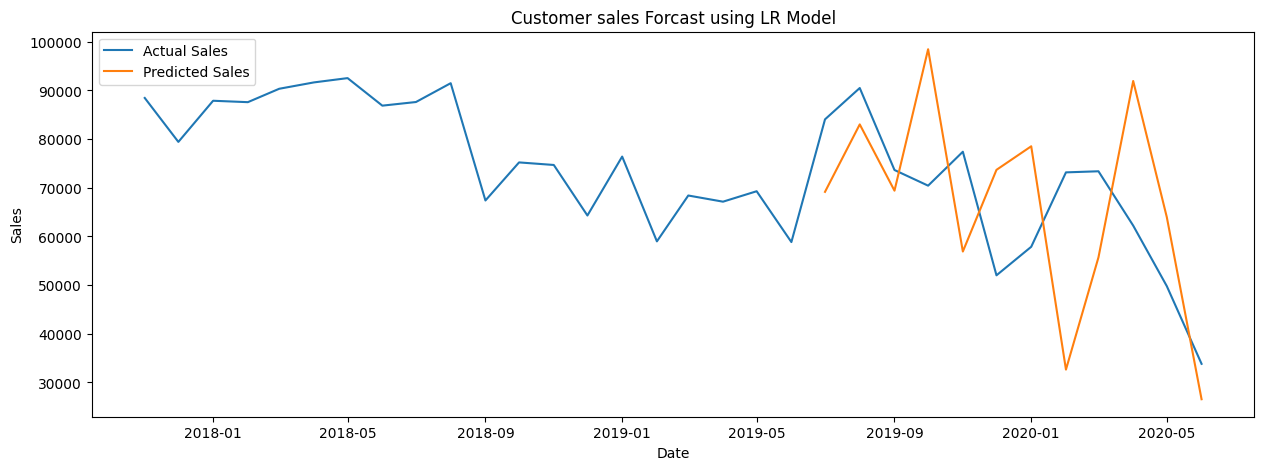

In [ ]:
plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(monthly_sales['date'],monthly_sales["sales"])
#Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer sales Forcast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Actual Sales", "Predicted Sales"])
plt.show()